Aleksei Shokhirev / Portfolio project 1

# Online retailer customer analysis

It is very important for companies to know their customers and understand their behavior well to be able to meet their needs and be successful. Now, we have a dataset of online retailer customer transactions. First, we will run Cohort analysis and compute metrics such as Retention rate and Churn rate. These metrics will allow us to understand customer trends. After that, we will compute Customer Lifetime Value (CLV) which is a measurement of how much a company expects to earn from an average customer in a lifetime. Then, we will run Recency/Frequency/Monetary/Tenure segmentation and create easy to interpret segments with K-mean clustering. On the top of that, we will predict customer transactions in the next month. 

# Read and explore data

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt
from empiricaldist import Cdf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from scipy import stats

In [2]:
retail = pd.read_excel('Online Retail.xlsx')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# check out for missing data
retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

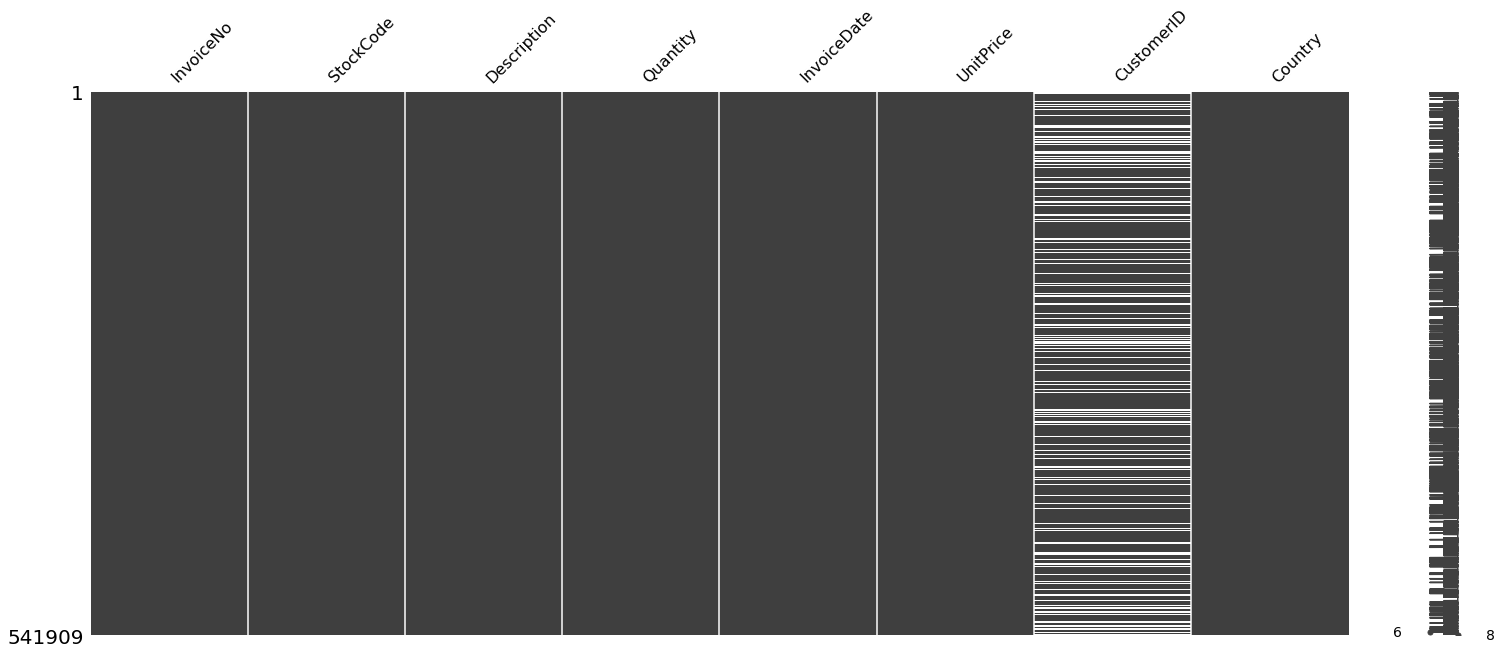

In [5]:
msno.matrix(retail)
plt.show()

In [6]:
# drop missing data
retail.dropna(subset = ['CustomerID'], inplace = True)

In [7]:
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
# convert CustomerID dtype to int64
retail['CustomerID'] = retail['CustomerID'].astype('int64')
assert retail['CustomerID'].dtype == 'int64'

In [9]:
# convert InvoiceNo dtype to int64
retail['InvoiceNo'] = pd.to_numeric(retail['InvoiceNo'], errors='coerce')

In [10]:
retail.isna().sum()

InvoiceNo      8905
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [11]:
# drop missing data
retail.dropna(subset = ['InvoiceNo'], inplace = True)
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
# convert InvoiceNo dtype to int64
retail['InvoiceNo'] = retail['InvoiceNo'].astype('int64')
assert retail['InvoiceNo'].dtype == 'int64'

In [13]:
# drop complete duplicates
retail.drop_duplicates(inplace=True)
retail[retail.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [14]:
# check key statistics of numeric variables
retail[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,392732.000000,392732.000000
mean,13.153718,3.125596
std,181.588420,22.240725
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [15]:
# drop UnitPrice = 0 data because it is missing data
retail = retail[retail['UnitPrice'] != 0]
retail[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,392692.000000,392692.000000
mean,13.119702,3.125914
std,180.492832,22.241836
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [16]:
# create extra column 'TotalSum'
retail['TotalSum'] = retail['Quantity'] * retail['UnitPrice']
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  int64         
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
 8   TotalSum     392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 30.0+ MB


# Exploratory data analysis

Now, we will explore the distribution of numerical variables 'Quantity', 'UnitPrice' and 'TotalSum' using cdf plot and box plot. 

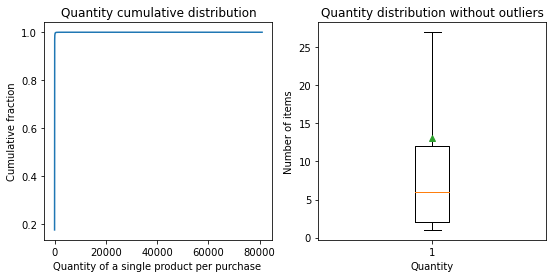

In [17]:
# compute Cdf - cumulative distribution of variables
Quantity_cdf = Cdf.from_seq(retail['Quantity'])
UnitPrice_cdf = Cdf.from_seq(retail['UnitPrice'])
TotalSum_cdf = Cdf.from_seq(retail['TotalSum'])

# create formulas for visualization
def cdf_plot(axes, x, xlabel, ylabel, title):
    axes.plot(x)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
def box_plot(axes, x, xlabel, ylabel, title, sym, showmeans):
    axes.boxplot(x, sym = sym, showmeans = showmeans)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)

# plot Quantity variable distribution
fig, ax = plt.subplots(1, 2, figsize = (9, 4))
cdf_plot(ax[0], Quantity_cdf, 'Quantity of a single product per purchase ', 'Cumulative fraction', 
         'Quantity cumulative distribution')
box_plot(ax[1], retail['Quantity'], 'Quantity', 'Number of items', 'Quantity distribution without outliers', '', True)
plt.show()

According to the Cdf chart, the maximum quantity of a single product per purchase was around 80 000. However, the box plot shows that around 97% of customers bought just 30 products of a single type per invoice or less, and only 3% of them made orders of more than 30 items. The median purchase was around 6 items, but the average quantity of a single product per invoice was nearly 12 or 2 times more. The reason for that difference is outliers, which means that a small number of customers purchased thousands of units of a single type per invoice.

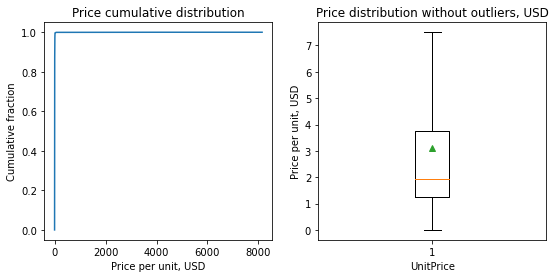

In [18]:
# plot UnitPrice variable distribution
fig, ax = plt.subplots(1, 2, figsize = (9, 4))
cdf_plot(ax[0], UnitPrice_cdf, 'Price per unit, USD', 'Cumulative fraction', 
         'Price cumulative distribution')
box_plot(ax[1], retail['UnitPrice'], 'UnitPrice', 'Price per unit, USD', 'Price distribution without outliers, USD', '', True)
plt.show()

The Cdf chart shows that the maximum unit price was around 8 000 USD. However, around 97 % them costed less than 8 dollars. The box plot indicates that 75% of items had price of less than 4 dollars. Moreover, the median price was just 2 USD. The average price per item was slightly above 3 dollars or 1.5 times more. That difference was caused by outliers or a small number of expensive products.

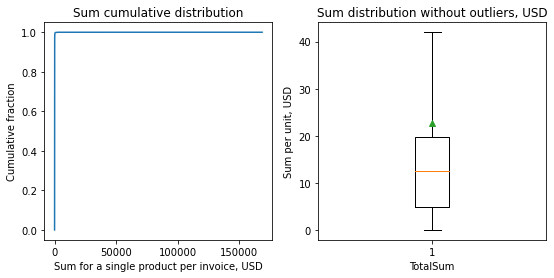

In [19]:
# plot TotalSum variable distribution
fig, ax = plt.subplots(1, 2, figsize = (9, 4))
cdf_plot(ax[0], TotalSum_cdf, 'Sum for a single product per invoice, USD', 'Cumulative fraction', 
         'Sum cumulative distribution')
box_plot(ax[1], retail['TotalSum'], 'TotalSum', 'Sum per unit, USD', 'Sum distribution without outliers, USD', '', True)
plt.show()

According to the box plot, the average sum for a single product per purchase was around 22 USD, but the median sum was just 12 dollars. The difference of around 1.8 times was caused by a small number of thousand-dollar purchases or outliers. The Cdf plot shows that the maximum sum for a single product per invoice was around 150 000 dollars. However, only 2% of purchases was 43 USD per product or more. Moreover, 75% of purchases was 19 dollars or less.

# Cohort analysis

Now, we will segment customers into acquisition cohorts based on the month the have made their first purchase. Each cohort will contain active customers for each month since the acquisition. Then we will calculate following metrics: 1. the retention rate - measuring how many customers from each cohort have returned in the subsequent month, 2. the churn rate - measuring how many customers from each cohort have churned in the subsequent month, 3. the average quantity of a single product per purchase for each cohort, 4. the average sum for a single product per invoice for each cohort.

In [20]:
# make sure our data is for 12 months from  2010-12-01 to 2011-12-01
print(retail['InvoiceDate'].min(), retail['InvoiceDate'].max())

2010-12-01 08:26:00 2011-12-09 12:50:00


In [21]:
retail = retail[retail['InvoiceDate'] <= '2011-12-01']
print(retail['InvoiceDate'].min(), retail['InvoiceDate'].max())

2010-12-01 08:26:00 2011-11-30 17:37:00


In [22]:
# assign acquisition month cohort
# create a function that truncate a given date object to a first day of the month
def get_month(x): return dt.datetime(x.year, x.month, 1)

# create 'InvoiceMonth' column
retail['InvoiceMonth'] = retail['InvoiceDate'].apply(get_month)

# assign minimum 'InvoiceMonth' value to 'CohortMonth' column
retail['CohortMonth'] = retail.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [23]:
# calculate time offset for each transaction which is anumber of months 
# between any transaction and first transaction for each customer
# first extract year, month and day
def get_data_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# create two objects with year and month integer values
invoice_year, invoice_month, _ = get_data_int(retail, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_data_int(retail, 'CohortMonth')

# compute the difference between them
years_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

# convert the total difference to month
retail['CohortIndex'] = years_diff * 12 + month_diff + 1 # + 1 means the first month is marked as 1

In [24]:
# compute the number of monthly active customers in each cohort
# first convert 'CohortMonth' dtype to strftime
retail['CohortMonth'] = retail['CohortMonth'].dt.strftime('%Y-%m-%d')

# count the number of unique customers in each group
cohort_data = retail.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

# create a pivot with monthly active customers
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'CustomerID')

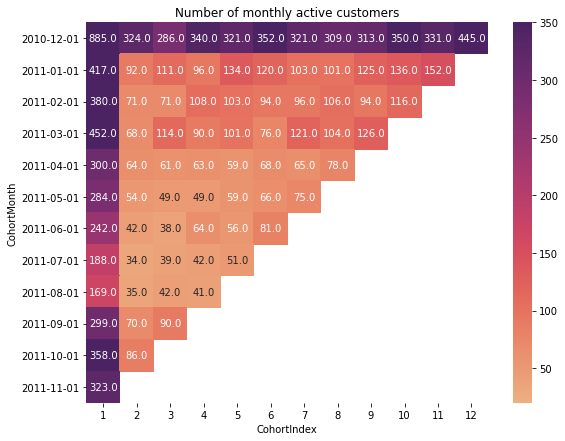

In [25]:
# visualize cohort_count
plt.figure(figsize = (9, 7))
sns.heatmap(data = cohort_counts, annot=True, cmap='flare', fmt='.1f', vmin=20, vmax=350)
plt.title('Number of monthly active customers')
plt.show()

# Cohort metrics

Now, we will calculate following metrics for each cohort: retention rate, churn rate, average quantity of a single product per purchase, average sum for a single product per invoice.

In [26]:
# compute retention rate
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# cumpute churn rate
churn = 1 - retention

# calculate the average quantity of unit for a single invoice
cohort_quantity = retail.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
average_quantity = cohort_quantity.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'Quantity')

# calculate the average unit sum for a single purchase
cohort_sum = retail.groupby(['CohortMonth', 'CohortIndex'])['TotalSum'].mean().reset_index()
average_sum = cohort_sum.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'TotalSum')

In [27]:
# compute overall mean across all four metrics
print('Overall mean retention: ', round(retention.iloc[:, 1:].mean().mean(), 3))
print('Overall mean churn: ', round(churn.iloc[:, 1:].mean().mean(), 3))
print('Overall mean quantity: ', round(average_quantity.mean().mean(), 1))
print('Overall mean sum: ', round(average_sum.mean().mean(), 1))

Overall mean retention:  0.298
Overall mean churn:  0.702
Overall mean quantity:  12.5
Overall mean sum:  21.4


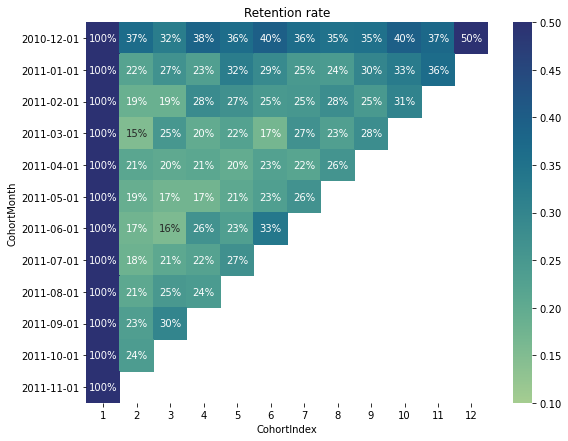

In [28]:
# visualize retention rate
plt.figure(figsize = (9, 7))
sns.heatmap(data = retention, annot=True, cmap='crest', fmt='.0%', vmin=0.1, vmax=0.5)
plt.title('Retention rate')
plt.show()

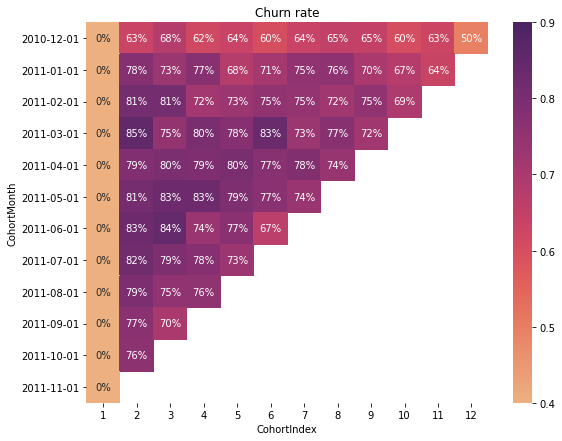

In [29]:
# visualize churn rate
plt.figure(figsize = (9, 7))
sns.heatmap(data = churn, annot=True, cmap='flare', fmt='.0%', vmin=0.4, vmax=0.9)
plt.title('Churn rate')
plt.show()

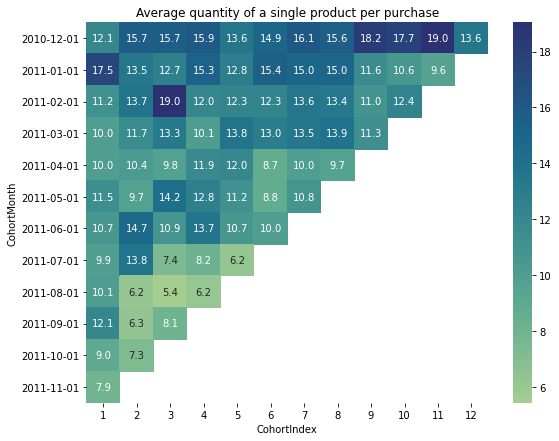

In [30]:
# visualize average quantity
plt.figure(figsize = (9, 7))
sns.heatmap(data = average_quantity, annot=True, cmap='crest', fmt='.1f')
plt.title('Average quantity of a single product per purchase')
plt.show()

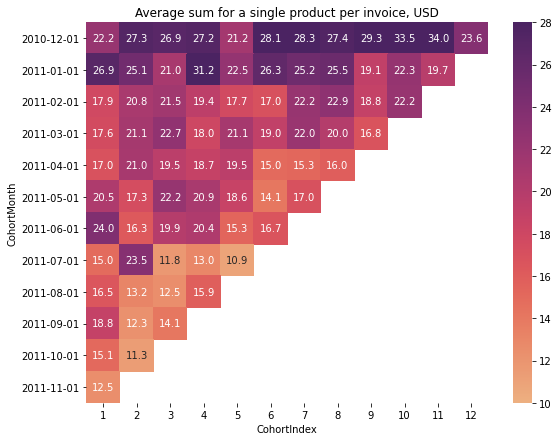

In [31]:
# visualize average invoice sum
plt.figure(figsize = (9, 7))
sns.heatmap(data = average_sum, annot=True, cmap='flare', fmt='.1f', vmin=10, vmax=28)
plt.title('Average sum for a single product per invoice, USD')
plt.show()

The cohort analysis charts show that customers who had longer relationship with the company demonstrated a better performance over all metrics  comparing to the overall mean of those metrics. Thus, the customers in cohorts '2010-12-01' and '2011-01-01' had higher retention rate, lower churn rate, they bought more products of a single type per invoice and spent more money for a single unit per purchase. But the rest of the cohorts with shorter relationship between customers and the company show worse values across all metrics comparing to the overall mean.  Moreover, the retention rate chart shows that the customer retention rate is in the region of 15%-40% across all cohorts. However, in 12-month time 50% of the customers returned for purchases. 

# Customer Lifetime Value (CLV)

Customer Lifetime Value is a measurement of how much a company expects to earn from an average customer in a lifetime. CLV allows to measure customer value in revenue or profit, benchmark customers and identify the maximum investment into customer acquisition. Now, we will use revenue based CLV because we do not have the profit margin data. Traditional CLV formula based on retention/churn ratio assumes that churn is final, and customer will not come back if they churn once. We cannot tell for sure that the churn is final. Moreover, traditional CLV method is not robust at low retention and Customer Lifetime Value will be under-reported. That is why we will use method based on purchase frequency and predefined customer lifespan = 36 month.

In [32]:
# calculate average revenue per invoice
revenue_per_purchase = retail.groupby('InvoiceNo')['TotalSum'].mean().mean()

# calculate average number of unique invoices per customer per month (frequency)
frequency_per_month = retail.groupby(['CustomerID', 'InvoiceMonth'])['InvoiceNo'].nunique().mean()

# define customer lifespan to 36 months
lifespan = 36

# compute CLV
clv = revenue_per_purchase * frequency_per_month * lifespan
print('Average CLV: {:.2f} USD'.format(clv))
print('Average revenue per purchase: {:.2f} USD'.format(revenue_per_purchase))
print('Average frequency per month: {:.2f}'.format(frequency_per_month))

Average CLV: 2937.14 USD
Average revenue per purchase: 57.16 USD
Average frequency per month: 1.43


# Recency, Frequency, Monetary, Tenure segmentation

Now, we will calculate four customer behavior metrics – Recency, Frequency, Monetary and Tenure. Recency measures how recent was each customer last purchase. Frequency measures how many purchases the customer has done in the last 12 months. Monetary measures how much each customer has spent in the last 12 months. Tenure measures the period since the first purchase. After that, we will use those four values to assign customers to RFMT segments and group them into some clusters based on their behavior. 

In [33]:
# first, take the last invoice date and add one more day
snapshot_day = retail['InvoiceDate'].max() + pd.Timedelta(days = 1)
snapshot_day

Timestamp('2011-12-01 17:37:00')

In [34]:
# calculate Recency, Frequency, Monetary variables
rfm_data = retail.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_day - x.max()).days, 
                                             'InvoiceNo':'count', 'TotalSum':'sum'})

# rename columns
rfm_data.rename(columns = {'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalSum':'Monetary'}, inplace = True)


# assign Tenure variable
tenure = retail.groupby('CustomerID').agg({'InvoiceDate': lambda y: (snapshot_day - y.min()).days})
rfmt_data = rfm_data.assign(Tenure = tenure['InvoiceDate'])
rfmt_data.head()

,Recency,Frequency,Monetary,Tenure
CustomerID,,,,
12346,317,1,77183.60,317
12347,31,171,4085.18,359
12348,67,31,1797.24,349
12349,10,73,1757.55,10
12350,302,17,334.40,302


In [35]:
# check key statistics of rfmt_data
rfmt_data.describe()

,Recency,Frequency,Monetary,Tenure
count,4297.000000,4297.00000,4297.000000,4297.000000
mean,91.460088,87.42518,1947.874902,216.894810
std,98.574043,213.64727,8351.696003,116.449211
min,1.000000,1.00000,2.900000,1.000000
25%,16.000000,17.00000,303.160000,109.000000
50%,50.000000,40.00000,650.750000,244.000000
75%,146.000000,96.00000,1594.230000,319.000000
max,365.000000,7212.00000,268478.000000,365.000000


# Data pre-processing for clustering

First, we need to check out the variable distributions for skewness. Then, we need to standardize variables to the same average values and scale them to the same std.

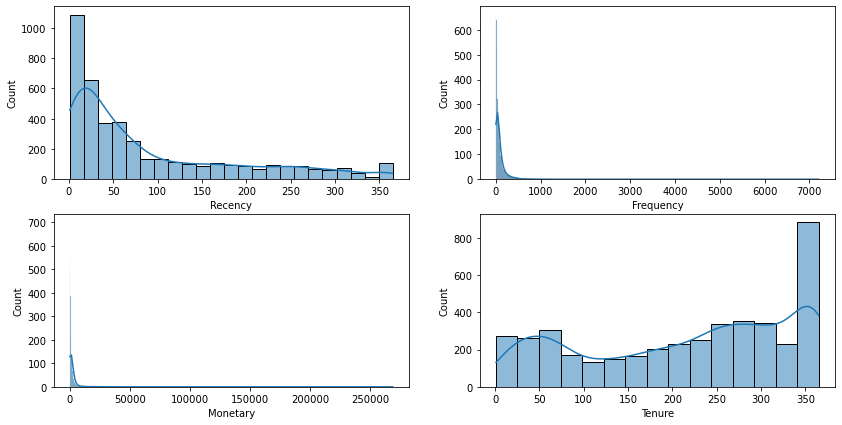

In [36]:
# check the data distribution to identify skewness
fig, ax = plt.subplots(2, 2, figsize = (14, 7))
sns.histplot(rfmt_data['Recency'], kde = True, ax = ax[0, 0])
sns.histplot(rfmt_data['Frequency'], kde = True, ax = ax[0, 1])
sns.histplot(rfmt_data['Monetary'], kde = True, ax = ax[1, 0])
sns.histplot(rfmt_data['Tenure'], kde = True, ax = ax[1, 1])
plt.show()

Recency, Frequency and Monetary variables have skewness. We need to transform our data to chenge variable distributions.

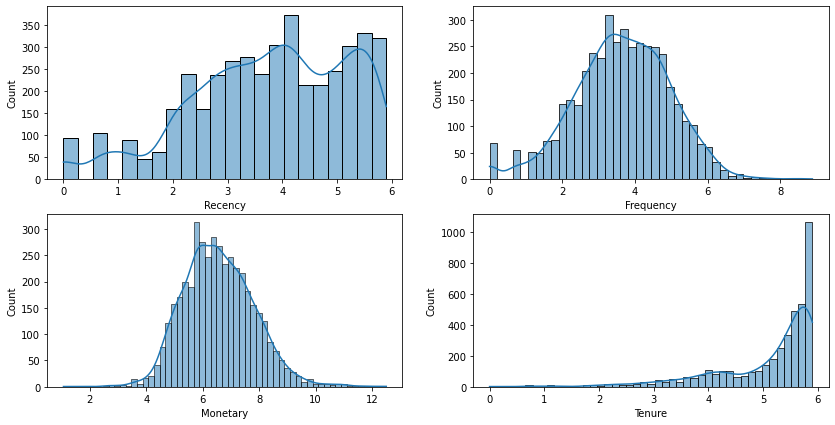

In [37]:
# apply log transformation
rfmt_data_log = np.log(rfmt_data)

# plot transform variables
fig, ax = plt.subplots(2, 2, figsize = (14, 7))
sns.histplot(rfmt_data_log['Recency'], kde = True, ax = ax[0, 0])
sns.histplot(rfmt_data_log['Frequency'], kde = True, ax = ax[0, 1])
sns.histplot(rfmt_data_log['Monetary'], kde = True, ax = ax[1, 0])
sns.histplot(rfmt_data_log['Tenure'], kde = True, ax = ax[1, 1])
plt.show()

The distribution of Tenure values is still having skewness. Transform data using Box-Cox transformation.

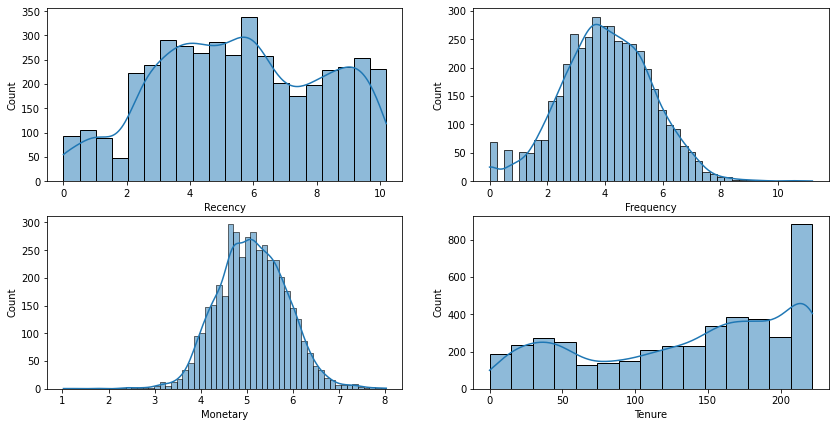

In [38]:
# Tenure variable has skewness.
# transform data using Box-Cox transformation technique
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox
rfmt_data_boxcox = rfmt_data.apply(boxcox_df, axis = 0)

# check the data distribution for skewness
fig, ax = plt.subplots(2, 2, figsize = (14, 7))
sns.histplot(rfmt_data_boxcox['Recency'], kde = True, ax = ax[0, 0])
sns.histplot(rfmt_data_boxcox['Frequency'], kde = True, ax = ax[0, 1])
sns.histplot(rfmt_data_boxcox['Monetary'], kde = True, ax = ax[1, 0])
sns.histplot(rfmt_data_boxcox['Tenure'], kde = True, ax = ax[1, 1])
plt.show()

The skewness is managed after applying Box-Cox transformation.

In [39]:
# check out if our data have the same mean and std
rfmt_data_boxcox.describe().round(2)

,Recency,Frequency,Monetary,Tenure
count,4297.00,4297.00,4297.00,4297.00
mean,5.59,4.05,5.11,136.21
std,2.63,1.57,0.75,69.22
min,0.00,0.00,1.02,0.00
25%,3.55,3.04,4.62,74.17
50%,5.57,4.05,5.10,154.14
75%,7.87,5.13,5.63,196.40
max,10.20,11.19,8.03,221.80


Both the average and std values are different between four variables. We need to center the mean and scale std.

In [40]:
# normalize our data with StandardScaler()
scaler = StandardScaler()
scaler.fit(rfmt_data_boxcox)
rfmt_norm = scaler.transform(rfmt_data_boxcox)

# create pandas DataFrame
rfmt_norm = pd.DataFrame(rfmt_norm, index = rfmt_data_boxcox.index, columns = rfmt_data_boxcox.columns)

# check if normalized data have the same mean and std
rfmt_norm.describe().round(2)

,Recency,Frequency,Monetary,Tenure
count,4297.00,4297.00,4297.00,4297.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.12,-2.59,-5.45,-1.97
25%,-0.78,-0.64,-0.65,-0.90
50%,-0.01,-0.00,-0.02,0.26
75%,0.86,0.69,0.68,0.87
max,1.75,4.55,3.88,1.24


All four variables have the same mean and std. Now, our data is prepared for clustering.

# Customer segmentation with K-means

First, we will identify the optimal number of clusters using Elbow criterion method. This method plots the sum of squared error (SSE) for each number of segments. Then we will look at the chart to identify where the decrease in SSE slow down and become marginal. This point represents the optimal number of clusters. Also, the best practice is to choose several options around the elbow to test what makes the most sense.

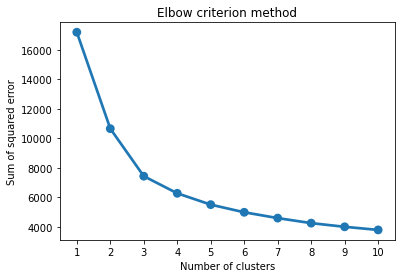

In [41]:
# calculate SSE for different number of clusters ranging from 1 to 10
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(rfmt_norm)
    sse[k] = kmeans.inertia_

# plot SSE for each 'k'
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared error')
plt.title('Elbow criterion method')
plt.show()

We can see the elbow is around 3-4 clusters. Now, we will review both options and identify which solution makes more sense.

In [42]:
# run K-means with 3 clusters on preprocessed data
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(rfmt_norm)

# extract cluster labels
cluster_labels_3 = kmeans.labels_

# create a Cluster column in the original dataset
rfmt_data_k3 = rfmt_data.assign(Cluster = cluster_labels_3)

# calculate average RFMT values and sizes for each cluster 
rfmt_data_k3_grouped = rfmt_data_k3.groupby('Cluster').agg({
    'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean', 'Tenure':['mean', 'count']})

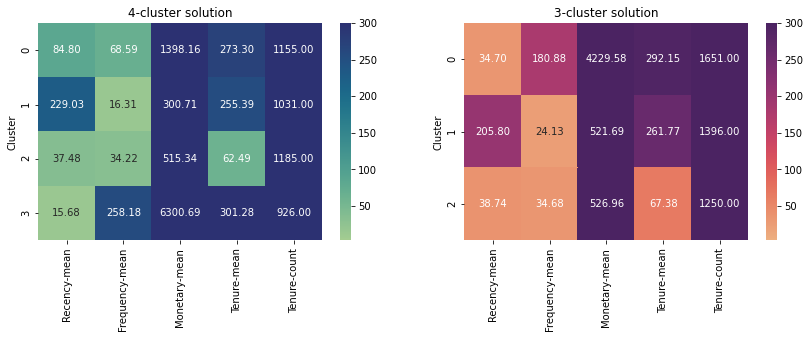

In [43]:
# run K-means with 4 clusters on preprocessed data
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(rfmt_norm)

# extract cluster labels
cluster_labels_4 = kmeans.labels_

# create a Cluster column in the original dataset
rfmt_data_k4 = rfmt_data.assign(Cluster = cluster_labels_4)

# calculate average RFMT values and sizes for each cluster 
rfmt_data_k4_grouped = rfmt_data_k4.groupby('Cluster').agg({
    'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean', 'Tenure':['mean', 'count']})

# plot both solutions
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14, 4))
sns.heatmap(data = rfmt_data_k4_grouped, annot=True, cmap='crest', fmt='.2f', vmin=3, vmax=300, ax=ax1)
sns.heatmap(data = rfmt_data_k3_grouped, annot=True, cmap='flare', fmt='.2f', vmin=3, vmax=300, ax=ax2)
ax1.set_title('4-cluster solution')
ax2.set_title('3-cluster solution')
ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

4-segment solution is a better choice because it provides more details, and we can immediately see the difference in RFMT values of those segments. In order to compare and understand our segments, we will create a snake plot and calculate relative importance of segment attributes. The snake plot is a visualization technique plotting segments and their RFMT values on a line plot. Relative importance of segments is the difference between our segments and overall population.

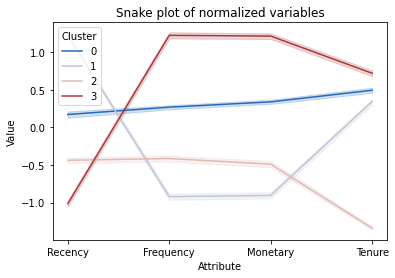

In [44]:
# visualize RFMT values between segments using snake plot
# first, add Cluster coulumn to rfmt_norm
rfmt_norm['Cluster'] = rfmt_data_k4['Cluster']

# melt rfmt_norm into the long format
rfmt_melt = pd.melt(rfmt_norm.reset_index(), id_vars = ['CustomerID', 'Cluster'], 
                    value_vars = ['Recency', 'Frequency', 'Monetary', 'Tenure'], 
                   var_name = 'Attribute', value_name = 'Value')

# create a snake plot
sns.lineplot(data = rfmt_melt, x = 'Attribute', y = 'Value', 
             hue = 'Cluster', palette = 'vlag')
plt.title('Snake plot of normalized variables')
plt.show()

The snake plot visually represents customer behavior for each cluster. We can clearly see that customers of cluster '3' bought products the most recently, the most frequently, spent the most amount of money and had the longest relationship with the company. Thus, cluster '3' represents the loyal customers named 'Loyal'. Cluster '1' customers were the least active recently, purchased the least frequently and spent the lowest amount of money. However, they had quite a long relationship with the company, that is why we can conclude that they churned and name that cluster as 'Churned'. Cluster '0' represents customers of middle performance across all four metrics, so we can name that cluster as 'Middle'. Finally, customers of cluster '2' had the shortest relationship with the company and the middle performance for the rest of the metrics. That is why it is a cluster of 'New' customers.

In [45]:
# rename the clusters to 'Loyal', 'Middle', 'New' and 'Churned'
rfmt_data_k4['Cluster'] = rfmt_data_k4['Cluster'].replace([0, 1, 2, 3], ['Middle', 'Churned', 'New', 'Loyal'])
rfmt_data_k4.head()

,Recency,Frequency,Monetary,Tenure,Cluster
CustomerID,,,,,
12346,317,1,77183.60,317,Middle
12347,31,171,4085.18,359,Loyal
12348,67,31,1797.24,349,Middle
12349,10,73,1757.55,10,New
12350,302,17,334.40,302,Churned


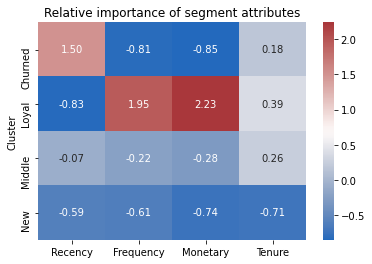

In [46]:
# compute and visualize relative importance of segment attributes
# first, calculate average RFMT values for each cluster
cluster_avg = rfmt_data_k4.groupby('Cluster').mean()

# calculate the mean for the total population
population_avg = rfmt_data.mean()

# finally, calculate importance score
relative_imp = cluster_avg / population_avg - 1

# visualize the relative scores for each claster
sns.heatmap(relative_imp, annot=True, fmt='.2f', cmap='vlag')
plt.title('Relative importance of segment attributes')
plt.show()

Zero is returned when cluster average = population average. As a ratio moves away from zero, the more important that attribute for defining a specific cluster compared to the population average. Thus, 'Monetary' is the most important attribute across three clusters except 'Churned' segment. 'Recency' is the least important for 'New' and 'Middle' clusters but the most important for 'Churned' segment. 'Frequency' is the third important attribute for 'Churned', 'Middle' and 'New' clusters and second important for 'Loyal' segment. 'Tenure' is the least important attribute for 'Churned' and 'Loyal' clusters, and second important for 'Middle' and 'New' segments.

Now, our segments are ready for targeting or other business applications!

# Predicting next month customer transactions

First, we will prepare data to predict next month transactions using linear regression. To build the input features we will start with Recency/Frequency/Monetary/Tenure/Quantity_avg/Quantity_sum variables. Then we will predict the number of purchases for the future month. We will use the last month in our dataset -2011-11-01 as the period for target variable. After that, we will add the other monthly customer purchase data (lagged data) as the input features on the top of RFMT features to test if they can improve the model performance. Lagged features are the same metrics as the target variable but are recorded prior to the event we are trying to predict. Finally, we will compute p_values to make sure the coefficients are significant and can be used for the model interpretation. 

In [47]:
# explore the sales distribution by month
retail.groupby('InvoiceMonth').size()

InvoiceMonth
2010-12-01    25670
2011-01-01    20988
2011-02-01    19706
2011-03-01    26870
2011-04-01    22433
2011-05-01    28073
2011-06-01    26926
2011-07-01    26580
2011-08-01    26790
2011-09-01    39669
2011-10-01    48793
2011-11-01    63168
dtype: int64

First, we will exclude the target month data (2011-11-01) from our dataset so we do not accidentally include these values into our features. Then we will build our features Recency/Frequency/Monetary/Tenure/Quantity_avg/Quantity_sum.

In [48]:
# exclude target variable data
retail_X = retail[retail['InvoiceMonth'] != '2011-11-01']

# define snapshot date
now = dt.datetime(2011,12,1)

# build features
features = retail_X.groupby('CustomerID').agg({
    'InvoiceDate':[lambda x: (now - x.max()).days, lambda x: (now - x.min()).days], 
    'InvoiceNo':pd.Series.nunique,
    'TotalSum':np.sum,
    'Quantity':['mean', 'sum']
}).reset_index()

# rename the columns
features.columns = ['CustomerID', 'Recency', 'Tenure', 'Frequency', 'Monetary', 'Quantity_avg', 'Quantity_sum']
features.head(2)

,CustomerID,Recency,Tenure,Frequency,Monetary,Quantity_avg,Quantity_sum
0,12346,316,316,1,77183.60,74215.000000,74215
1,12347,30,358,6,4085.18,13.251462,2266


We have a row for each customer with six features Recency/Frequency/Monetary/Tenure/Quantity_avg/Quantity_sum.

Define a target variable. Here, we will build a pandas pivot table with customers as rows, InvoiceMonce as a columns, and a number of invoice counts as values. We will use 2011-11-01 values as the target variable.

In [49]:
cust_month_tx = pd.pivot_table(data = retail, index = ['CustomerID'], values = 'InvoiceNo', 
                               columns = 'InvoiceMonth', aggfunc = pd.Series.nunique, 
                              fill_value = 0)

cust_month_tx.columns = cust_month_tx.columns.astype('str')
assert cust_month_tx.columns.dtype == 'object'

In [50]:
# make sure the features and target datasets have the same shape
# eg the same number of customers
cust_month_tx = cust_month_tx.reset_index()
target_table = cust_month_tx[cust_month_tx['CustomerID'].isin(features['CustomerID'])]
target_table.columns

Index(['CustomerID', '2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
       '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
       '2011-09-01', '2011-10-01', '2011-11-01'],
      dtype='object', name='InvoiceMonth')

In [54]:
# create features and target variable
X = features.drop('CustomerID', axis = 1)
y = target_table['2011-11-01']

# split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

# instantiate LinearRegression
linreg = LinearRegression()

# fit the model on the training data
linreg.fit(X_train, y_train)

# predict values on both training and test data
train_pred_y = linreg.predict(X_train)
test_pred_y = linreg.predict(X_test)

# calculate RMSE and MAE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mae_train = mean_absolute_error(y_train, train_pred_y)

# calculate metrics for testing data
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))
mae_test = mean_absolute_error(y_test, test_pred_y)

# compute R-squared
R_squared = linreg.score(X_test, y_test)

# print performance metrics
print('RMSE train: {:.3f}; RMSE test: {:.3f}\nMAE train: {:.3f}; MAE test: {:.3f}\nR_squared: {:.3f}'
      .format(rmse_train, rmse_test, mae_train, mae_test, R_squared))

RMSE train: 0.823; RMSE test: 1.552
MAE train: 0.586; MAE test: 0.626
R_squared: 0.448


R_squared is the percentage of explained variance. As we can see, our model explained around 44.8% of the variance. The errors are slightly higher for the testing data, which is expected, as the training data were used in model building and match the pattern better than in unseen testing data. MAE is smaller than RMSE as it less sensitive to outliers where the error is higher, which means RMSE emphasized by squaring them. MAE indicates that comparing actual transaction in November 2011 to the predicted transaction in November 2011 our model is off by roughly more than half transaction. Now, we will add lagged features on the top of six existing features - Recency/Frequency/Monetary/Tenure/Quantity_avg/Quantity_sum and check if they can improve the model performance. 

In [55]:
# adding extra lagged features
features_ext = features.merge(target_table, on='CustomerID')
features_ext.columns

Index(['CustomerID', 'Recency', 'Tenure', 'Frequency', 'Monetary',
       'Quantity_avg', 'Quantity_sum', '2010-12-01', '2011-01-01',
       '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-01', '2011-06-01',
       '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01'],
      dtype='object')

In [56]:
# create features and target variable
X = features_ext.drop(['CustomerID', '2011-11-01'], axis = 1)
y = target_table['2011-11-01']

# split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

# instantiate LinearRegression
linreg = LinearRegression()

# fit the model on the training data
linreg.fit(X_train, y_train)

# predict values on both training and test data
train_pred_y = linreg.predict(X_train)
test_pred_y = linreg.predict(X_test)

# calculate RMSE and MAE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mae_train = mean_absolute_error(y_train, train_pred_y)

# calculate metrics for testing data
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))
mae_test = mean_absolute_error(y_test, test_pred_y)

# compute R-squared
R_squared = linreg.score(X_test, y_test)

# print performance metrics
print('RMSE train: {:.3f}; RMSE test: {:.3f}\nMAE train: {:.3f}; MAE test: {:.3f}\nR_squared: {:.3f}'
      .format(rmse_train, rmse_test, mae_train, mae_test, R_squared))

RMSE train: 0.810; RMSE test: 1.482
MAE train: 0.575; MAE test: 0.620
R_squared: 0.496


By adding lagged features we slightly improved the model performance. The model explained around 49.6% of the variance. Now, we want to make sure the coefficients are not random, and they can be used for the model interpretation. Using statsmodels library compute p-values or the statistical significance of coefficients with the standard threshold = 95%. 

In [57]:
# convert target variable to numpy array
y_train = np.array(y_train)

# instantiate and fit the model
olsreg = sm.OLS(y_train, X_train)
olsreg = olsreg.fit()

# compute p_values
olsreg.pvalues

Recency          6.294381e-01
Tenure           4.680465e-03
Frequency       2.359888e-113
Monetary         7.889464e-01
Quantity_avg     5.730710e-02
Quantity_sum     1.226808e-01
2010-12-01       6.205643e-03
2011-01-01       9.803098e-01
2011-02-01       2.736890e-06
2011-03-01       2.622217e-01
2011-04-01       6.668537e-04
2011-05-01       4.269559e-01
2011-06-01       6.770755e-01
2011-07-01       1.785628e-02
2011-08-01       1.471647e-01
2011-09-01       1.724302e-16
2011-10-01       1.122939e-11
dtype: float64

We can conclude, that following features are statistically significant and can be used for the model interpretation - Tenure, Frequency, 2010-12-01, 2011-02-01, 2011-04-01, 2011-07-01, 2011-09-01, 2011-10-01.

# Conclusion

To sum up, in this project we performed Exploratory data analysis, Cohort analysis, calculated Customer Lifetime Value, made Recency/Frequency/Monetary/Tenure segmentation, and predicted next month customer transactions. According to the EDA, customers bought 12 products of a single type per invoice, with the price of 3 dollars for each item and spent 22 USD for a single product per purchase on average. However, the small number of customers bought up to 80 000 items of a single type per invoice and spent over 100 000 USD for purchasing a single unit type per invoice. The maximum unit price was around 8 000 dollars. The Cohort analysis shows that the customers who had longer relationship with the company demonstrated better performance across all metrics. Thus, the overall mean retention is around 30%, but the customers in cohort 2010-12-01 had retention rate in the region of 32%-50%. Moreover, we can clearly see that in 12 months 50% of the customers returned for purchases. Customer Lifetime Value is 2937,14 USD. Now, we can use that data to calculate how much the company can invest to the customer acquisition. Also, we clustered our data into four segments – ‘Loyal’, ‘Middle’, ‘New’ and ‘Churned’ representing different customer behavior across Recency, Frequency, Monetary and Tenure metrics. Those clusters can be used for targeting or other business applications. Finally, we predicted next month customer transactions. 